In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import os
import cv2
import random
random.seed(42)
from sklearn.preprocessing import normalize
import pickle

from scipy.spatial import distance

In [2]:
HOME="./Faces_FA_FB/"
fa_H="fa_H"
fa_L="fa_L"
fb_H="fb_H"
fb_L="fb_L"

training_location_H=HOME+"/"+fa_H
testing_location_H=HOME+"/"+fb_H
training_location_L=HOME+"/"+fa_L
testing_location_L=HOME+"/"+fb_L

In [3]:
def get_images_id(location):
    images_name=[]
    for file in os.listdir(location):
        if file.endswith(".pgm"):
            images_name.append(file)

    data_id=np.array([x[:5] for x in images_name])
    images=np.array([cv2.imread(location+"/"+x) for x in images_name])
    return images,data_id

# training_images_H,training_data_id_H=get_images_id(training_location_H)
testing_images_H,testing_data_id_H=get_images_id(testing_location_H)
# training_images_L,training_data_id_L=get_images_id(training_location_L)
testing_images_L,testing_data_id_L=get_images_id(testing_location_L)


In [4]:
np.sum(np.array([1 for a in testing_data_id_L if int(a)<=140]))

84

In [5]:
def show_multiple_images_10(images,title=None):
    rows=int(len(images)/5)
    if rows%1>0:
        rows=rows+1
    columns=5
    fig = plt.figure(figsize=(1.5*columns,1.5*rows))
    if title:
        fig.suptitle(title,fontsize=10)
    
    for i in range(len(images)):
        # Adds a subplot at the 1st position
        fig.add_subplot(rows, columns, i+1)
        # showing image
        plt.imshow(images[i],cmap='gray')
        plt.axis('off')
        plt.savefig("a_I_largest_10.svg",dpi=300,format='svg')
        

In [6]:
class MyPCA_testing:
    
    def __init__(self, read_pickle_model, information=100):
        self.read_pickle_model=read_pickle_model
        self.information=information
        self.find_components()
        
    def find_components(self):        
        with open(self.read_pickle_model,'rb') as filehandler:
            object_file = pickle.load(filehandler)
        self.projections,self.mean,self.eig_vals_sorted,self.eig_vecs_sorted,self.data_id=object_file
        
        image_shape=np.array(self.mean).shape
#         self.mean=np.array(self.mean).flatten()
        #Finding n_components from teh amount of information to take
        if self.information>1:
            self.information=self.information/100
        if self.information!=None:
            info_cumsum=np.cumsum(self.eig_vals_sorted)
            
            info_cumsum_percent=np.array(info_cumsum)/info_cumsum[-1]
            for i in range(len(info_cumsum)):
                if info_cumsum_percent[i]>=self.information:
                    self.n_components=i
                    break
                    
        self.components =self. eig_vecs_sorted[:self.n_components]
        self.eign_val_components = self.eig_vals_sorted[:self.n_components]
        self.projections=self.projections[:,:self.n_components]
    
    def distance_with_faces(self,x):
        inverse_eigen_val_matrix=np.diag(1/self.eign_val_components)
        distances=[distance.mahalanobis(x,a,inverse_eigen_val_matrix) for a in self.projections]
        return distances
        
    def predict_a_face(self, item, r):
        P = item[:,:,0].copy()
        P = (P - self.mean).flatten()
        P_proj=self.components.dot(P)
        
        distances=self.distance_with_faces(P_proj)
        sorted_arg=np.argsort(distances)
        args_to_see=sorted_arg[:r]
        np.array([self.data_id[x] for x in args_to_see])
        
    def predict_intrusion(self,item,threshold):
        P = item[:,:,0].copy()
        P = (P - self.mean).flatten()
        P_proj=self.components.dot(P)
        
        distance=self.distance_with_faces(P_proj)
        if distance>threshold:
            return 0
        else:
            return 1


    def predict_intrusion_distance(self,item):
        P = item[:,:,0].copy()
        P = (P - self.mean).flatten()
        P_proj=self.components.dot(P)
        
        distances=self.distance_with_faces(P_proj)
        sorted_distance=np.sort(distances)
        return sorted_distance[0]
        
    
    def getMean(self):
        return self.mean
    
    def getComponents(self):
        return self.components
    
    def getProjections(self):
        return self.projections
    
    def getDataId(self):
        return self.data_id

In [7]:
def TPR_FPR_given_threshold(truth_value, prediction_distances, threshold):
    prediction=[1 if dist<threshold else 0 for dist in prediction_distances]
    
    intruders_predicted_set=np.array([e for i ,e in enumerate(prediction) if truth_value[i]==0])
    FPR=np.sum(intruders_predicted_set)/len(intruders_predicted_set)
    non_intruders_predicted_set=[e for i ,e in enumerate(prediction) if truth_value[i]==1]
    TPR=np.sum(np.array(non_intruders_predicted_set))/len(non_intruders_predicted_set)
#     print(len(non_intruders_predicted_set),len(intruders_predicted_set))
    
    return TPR,FPR


84 1119 1196


Text(0.5, 1.0, 'ROC curve when using high resolution images')

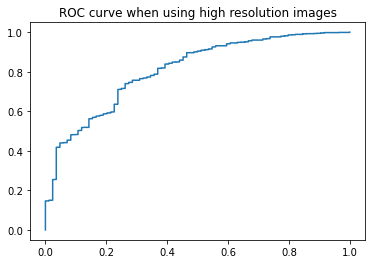

In [8]:
PCA1=MyPCA_testing(read_pickle_model="High_50_images.pickle",information=95)

prediction_dis=[PCA1.predict_intrusion_distance(testing_images_H[i]) for i in range(len(testing_data_id_H))]
# print(prediction_dis)
non_intruders=PCA1.getDataId()
truth_value=np.array([1 if testing_data_id_H[i] in non_intruders else 0 for i in range(len(testing_data_id_H)) ])
intruders=[x for x in testing_data_id_H if x not in non_intruders]


print(len(intruders),len(non_intruders),len(truth_value))

rates_h=[TPR_FPR_given_threshold(truth_value=truth_value,
                                 prediction_distances=prediction_dis,
                                 threshold=t
                                ) for t in np.arange(0,1,.0001)]


Text(0.5, 1.0, 'ROC curve when using high resolution images')

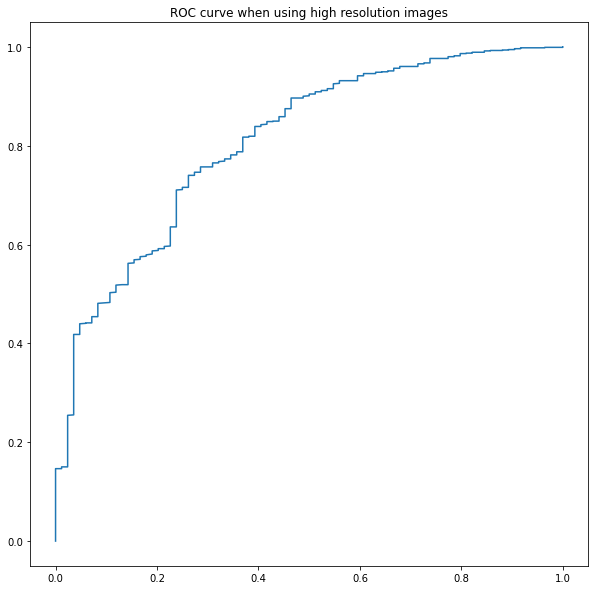

In [17]:
fig=plt.figure(figsize=(10,10))
plt.plot(np.array(rates_h).T[1],np.array(rates_h).T[0])
plt.title("ROC curve when using high resolution images")

Text(0.5, 1.0, 'ROC curve when using low resolution images')

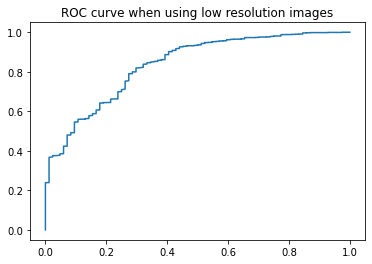

In [9]:
PCA2=MyPCA_testing(read_pickle_model="Low_50_images.pickle",information=95)

prediction_dis=[PCA2.predict_intrusion_distance(testing_images_L[i]) for i in range(len(testing_data_id_L))]
# print(prediction_dis)
non_intruders=PCA1.getDataId()
truth_value=np.array([1 if testing_data_id_L[i] in non_intruders else 0 for i in range(len(testing_data_id_L)) ])
intruders=[x for x in testing_data_id_H if x not in non_intruders]

rates_l=[TPR_FPR_given_threshold(truth_value,
                                 prediction_distances=prediction_dis,
                                 threshold=t
                                ) for t in np.arange(0,5,.0001)]

plt.plot(np.array(rates_l).T[1],np.array(rates_l).T[0])
plt.title("ROC curve when using low resolution images")

Text(0.5, 1.0, 'ROC curve when using low resolution images')

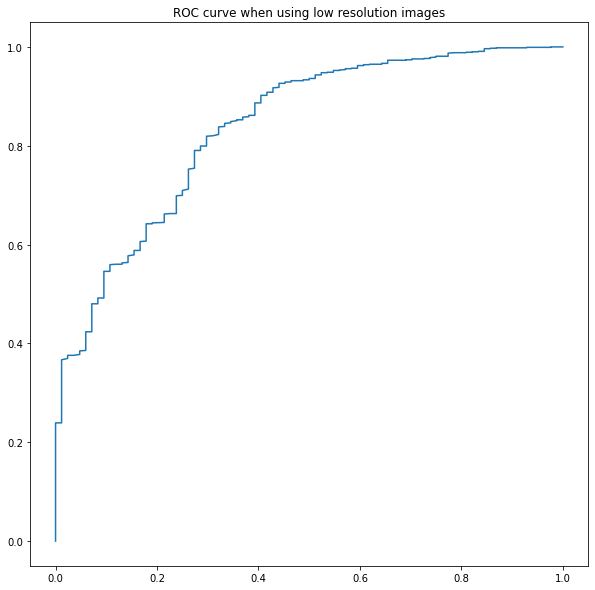

In [21]:
fig=plt.figure(figsize=(10,10))
plt.plot(np.array(rates_l).T[1],np.array(rates_l).T[0])
plt.title("ROC curve when using low resolution images")

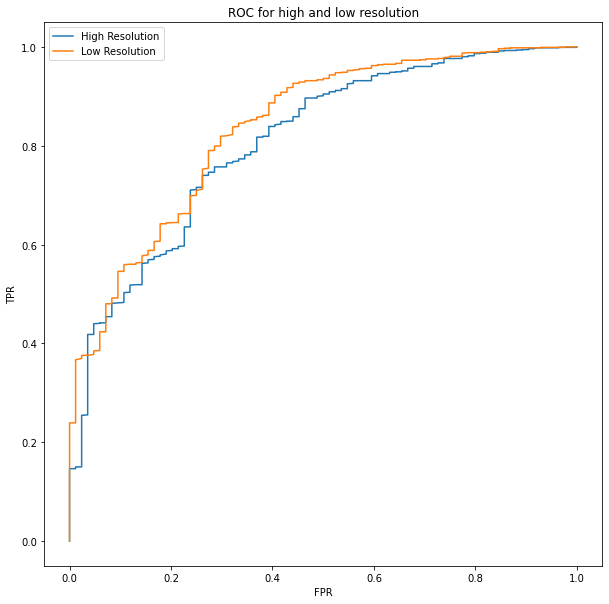

In [20]:
fig=plt.figure(figsize=(10,10))
plt.plot(np.array(rates_h).T[1],np.array(rates_h).T[0])
plt.plot(np.array(rates_l).T[1],np.array(rates_l).T[0])
plt.legend(['High Resolution', 'Low Resolution'])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title(f"ROC for high and low resolution")
plt.show()

In [11]:
# non_intruders=PCA1.getDataId()
# # truth_value=np.array([1 if testing_data_id_H[i] in non_intruders else 0 for i in range(len(testing_data_id_H)) ])
# intruders_predicted_set=np.array([e for i ,e in enumerate(prediction) if truth_value[i]==0])
# # FPR=np.sum(1-intruders_predicted_set)/len(intruders_predicted_set)
# non_intruders_predicted_set=[e for i ,e in enumerate(prediction) if truth_value[i]==1]


In [12]:
# PCA1=MyPCA_testing(read_pickle_model="High_50_images.pickle",information=95)
# prediction=[PCA1.predict_intrusion(testing_images_H[i],0.1) for i in range(len(testing_data_id_H))]
# non_intruders=PCA1.getDataId()
# truth_value=np.array([1 if testing_data_id_H[i] in non_intruders else 0 for i in range(len(testing_data_id_H)) ])
# intruders_predicted_set=np.array([e for i ,e in enumerate(prediction) if truth_value[i]==0])
# FPR=np.sum(1-intruders_predicted_set)/len(intruders_predicted_set)
# non_intruders_predicted_set=[e for i ,e in enumerate(prediction) if truth_value[i]==1]
# TPR=np.sum(np.array(non_intruders_predicted_set))/len(non_intruders)
# FPR,TPR

In [13]:
# PCA1=MyPCA_testing(read_pickle_model="High_50_images.pickle",information=80)
# prediction=[PCA1.predict_intrusion(testing_images_H[i],0.1) for i in range(len(testing_data_id_H))]
# non_intruders=PCA1.getDataId()
# truth_value=np.array([1 if testing_data_id_H[i] in non_intruders else 0 for i in range(len(testing_data_id_H)) ])
# intruders_predicted_set=np.array([e for i ,e in enumerate(prediction) if truth_value[i]==0])
# FPR=np.sum(1-intruders_predicted_set)/len(intruders_predicted_set)
# non_intruders_predicted_set=[e for i ,e in enumerate(prediction) if truth_value[i]==1]
# TPR=np.sum(np.array(non_intruders_predicted_set))/len(non_intruders)
# FPR,TPR

In [14]:
# def create_ROC(model,testing_images,testing_data_id,title):
#     non_intruders=PCA1.getDataId()
#     truth_value=np.array([1 if testing_data_id[i] in non_intruders else 0 for i in range(len(testing_data_id))])
#     FPR=[]
#     TPR=[]
#     for threshold in np.arange(0.3,0.8,0.02):
#         prediction=[PCA1.predict_intrusion(testing_images[i],threshold) for i in range(len(testing_data_id))]
#         intruders_predicted_set=np.array([e for i ,e in enumerate(prediction) if truth_value[i]==0])
#         FPRx=np.sum(intruders_predicted_set)/len(intruders_predicted_set)
#         non_intruders_predicted_set=[e for i ,e in enumerate(prediction) if truth_value[i]==1]
#         TPRx=np.sum(np.array(non_intruders_predicted_set))/len(non_intruders)
#         FPR.append(FPRx)
#         TPR.append(TPRx)
#     print(FPR,TPR)
#     plt.plot(FPR,TPR)
#     plt.xlim(0,1)
#     plt.ylim(0,1)
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title(title)
#     plt.show()
#     return  TPR,FPR
        


In [15]:
# PCA1=MyPCA_testing(read_pickle_model="High_50_images.pickle",information=95)       
# TPR_h,FPR_h=create_ROC(model=PCA1,
#            testing_images=testing_images_H,
#            testing_data_id=testing_data_id_H,
#            title="ROC curve for high resolution images"
#           )       

In [16]:
# PCA1=MyPCA_testing(read_pickle_model="Low_50_images.pickle",information=95)       
# TPR_l,FPR_l=create_ROC(model=PCA1,
#            testing_images=testing_images_L,
#            testing_data_id=testing_data_id_L,
#            title="ROC curve for high resolution images"
#           )       